In [107]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pylab import figure, cm
from jax import grad, hessian, jit, vmap
import time
from functools import partial
from IPython.display import clear_output

N = 2
# true_E = N*omega/2 -  g**2/24 * N * (N**2 - 1)
omega = 1
g = 1
hbar = 1
m = 1

In [108]:

class Network:
    def __init__(self, node_counts=[N, 10, 5, 1]):
        # defining the structure of the neural network
        self.num_layers = len(node_counts)
        # the number of nodes for each layer
        self.node_counts = node_counts
        # the total number of weights
        self.params_length = 0
        for i in range(self.num_layers - 1):
            self.params_length += node_counts[i] * node_counts[i + 1]
            i+=1
        # the list that stores the weight matrices (index 0 is the connections from the input to the first hidden layer)
        self.weights = []
        # generate weight matrices with the correct sizes, and random elements
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.randn(node_counts[i + 1], node_counts[i]) * np.sqrt(1. / node_counts[i + 1]))
        self.weights = np.array(self.weights, dtype=object)
        
        # get the shape for reshaping a 1d array to this later
        self.dimensions = []
        for m in self.weights:
            self.dimensions.append(m.shape)

    # define the activation function that we use for the layers
    @partial(jit, static_argnums=[0])
    def l_act(self, x):
        return x / (jnp.abs(x) + 1)
    
    # define the activation function for the output
    @partial(jit, static_argnums=[0])
    def o_act(self, x):
        return jnp.max(0,x)
    
    @partial(jit, static_argnums=(0,))
    def conv1d(self):
        #start = time.time()
        flattened = []
        # loop through each matrix
        for m in range(self.num_layers - 1):
            mat = self.weights[m]
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    flattened.append(mat[i][j])
        #end = time.time()
        #print("conv1d: " + str(end - start))
        return jnp.array(flattened)
        
    @partial(jit, static_argnums=(0,))
    def convnd(self, params):
        #start = time.time()
        ret = []
        # the last index of the matrix
        max_ind = 0
        prev_ind = 0
        for dim in self.dimensions:
            max_ind += dim[0]*dim[1]
            temp = params[prev_ind : max_ind]
            prev_ind = max_ind
            ret.append(jnp.array(temp).reshape(dim))
        #end = time.time()
        #print("convnd: " + str(end - start))
        return ret


    # passing inputs into the neural network and getting an output
    @partial(jit, static_argnums=[0])
    def output(self, coords, params):
        # start = time.time()
        # sort the input coordinates in order to enforce particle swap invariance
        coords = jnp.asarray(coords)
        jnp.sort(coords)
        # format the parameters as weights
        self.weights = self.convnd(params)
        # compute the output of the neural network
        for i in range(self.num_layers - 1):
            w = jnp.array(self.weights[i])
            # if its the first layer, dot it against the input and use the activation function
            if i == 0:
                temp = self.l_act(jnp.dot(w, coords))
            elif (i < self.num_layers):
                temp = self.l_act(jnp.dot(w, temp))
            else:
                # on the output layer we se the output activation function
                temp = self.o_act(jnp.dot(w, temp))
        # print("output:" + str(time.time() -  start))
        return temp[0]

# create the network object
nn = Network()

# defines the wavefunction based on calls to the neural network
@jit
def psi(coords, params):
    return jnp.exp(-nn.output(coords, params))

def sample(params, num_particles, num_samples):
    # random.seed(seed)
    outputs = []
    coords_t = np.zeros(num_particles)
    for _ in range(num_samples):
        coords_prime = coords_t + np.random.uniform(-1,1,num_particles)
        if (np.random.uniform(0,1) < psi(coords_prime, params)**2/psi(coords_t, params)**2):
            coords_t = coords_prime
        outputs.append(coords_t)
    return jnp.array(outputs)


# computes the hessian matrix, has all the second order partials
h = hessian(psi)
# return the second derivative of the wavefunction with respect to every parameter
@jit
def ddpsi(coords, params):
    return jnp.diagonal(h(coords, params))

# to compute the energy, we want to split it into repeated chunks
# 1/psi * H psi
@partial(jit, static_argnums=[2,3,4])
def energy(coords, params, omega, g, num_particles):
    result = 0
    # first get the value of the wavefunction to store
    temppsi = psi(coords, params)
    # then loop over all particles
    for i in range(num_particles):
        # harmonic oscillator potential and second derivative
        result += .5*m*omega**2*coords[i]**2*temppsi - hbar**2/(2*m) * jnp.sum(ddpsi(coords, params))
    # now moving to the second section
    for j in range(1, num_particles):
        for i in range(j - 1):
            result -= temppsi * m * omega * g/hbar * jnp.abs(coords[i] - coords[j])
            # the delta function part
            # get the modified input, make coords[i] and coords[j] the same
            delta = jnp.copy(coords)
            delta = delta.at[i].set(delta[j])
            result += g * psi(delta, params)
    return result * (1/temppsi)

venergy = vmap(energy, in_axes=(0, None, None, None, None), out_axes=0)

# dlogpsi/dtheta
@jit
def logpsi(coords, params):
    return jnp.log(psi(coords, params))

# define the derivative with respect to every parameter of the log of psi:
dlogpsi_dtheta_stored = jit(grad(logpsi, 1))

vlog_term = vmap(dlogpsi_dtheta_stored, in_axes=(0, None), out_axes=0)

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def avg_energy(params, omega, g, num_particles, num_samples=10**3):
    # first we get a set of samples
    samples = sample(params, num_particles, num_samples)
    # then use MC integration
    energies = []
    for s in samples:
        energies.append(energy(s, params,omega,g,num_particles))
    return (1/num_samples)*jnp.sum(jnp.array(energies))
    #return (1/num_samples) * jnp.sum(venergy(samples, params, omega, g, num_particles),0)

def gradient(params, omega, g, num_particles, num_samples=10**3):
    # get the samples
    samples = sample(params, num_particles, num_samples)
    psiHpsi = venergy(samples, params, omega, g, num_particles)
    logs = vlog_term(samples, params)
    
    energy = 1/num_samples * jnp.sum(psiHpsi)
    log_term = 1/num_samples * jnp.sum(logs,0)

    both = 1/num_samples * jnp.sum(vboth(psiHpsi, logs),0)

    gradient_calc = (2 * both - 2*energy * log_term)
    return gradient_calc

def vgrad_opt(start_params, omega, g, num_particles, num_samples=10**3, learning_rate=.1, max_iterations=100, tolerance=.01,):
    params = start_params
    hist = [start_params]

    for it in range(max_iterations):
        clear_output(wait=True)
        diff = jnp.asarray((learning_rate * gradient(params, omega, g, num_particles, num_samples)))
        print(diff)
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [109]:
# checking whether the neural network output matches what it should be
# set the weights to something manually:

# manual_weights = [.5,.5,.5,.5,.5,.5,.5,.5,.5]
# nn.weights = nn.convnd(jnp.array(manual_weights))
# print(nn.weights)
# print(nn.output([1.0,1.0], jnp.array(manual_weights)))

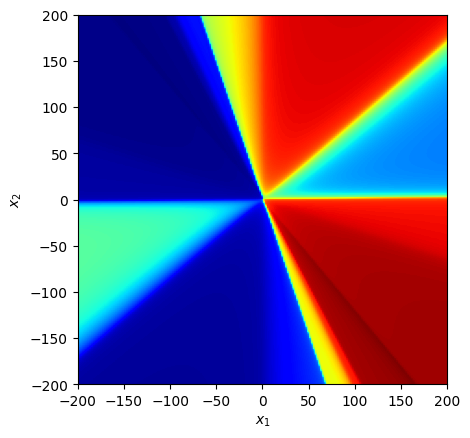

In [110]:
# plotting the wavefunction
size = 200
xmin = -200
xmax = 200
ymin = -200
ymax = 200
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
mesh = [[psi([i, j], nn.conv1d()) for i in X] for j in Y]
fig = plt.figure()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
im = plt.imshow(mesh, cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')
plt.show()

In [111]:
print(avg_energy(nn.conv1d(), omega,g,N,10**3))
print(avg_energy(nn.conv1d(), omega,g,N,10**3))
print(avg_energy(nn.conv1d(), omega,g,N,10**3))
print(avg_energy(nn.conv1d(), omega,g,N,10**3))
print(avg_energy(nn.conv1d(), omega,g,N,10**3))

330.1729
186.37437
110.039925
87.711845
72.74248


In [112]:
#print(gradient(nn.conv1d(),1,1,2))
#print(psi([1.0,1.0], nn.conv1d()))
optd = vgrad_opt(nn.conv1d(), omega,g,N)
print(optd[-1])

[ 1.46649184e-03 -1.41762542e-02  4.54237452e-03 -5.24047725e-02
 -4.25328985e-02  7.51286075e-02 -1.77275611e-03 -2.68948101e-03
 -2.10161484e-03 -1.61587202e-03  5.56319058e-02 -1.02477983e-01
 -3.77939343e-02  8.16669986e-02 -5.88996941e-03 -5.76393353e-03
 -6.12672232e-02  1.07707858e-01 -1.38375827e-03 -1.57505367e-03
  1.79664046e-03  8.87093134e-04  2.63251248e-03 -1.70369446e-03
 -9.70752561e-04  3.40221071e-04  1.25308332e-04 -7.30901957e-05
  9.67044383e-04  1.80552903e-04 -2.60201399e-03  3.95917753e-03
  5.42459358e-03  3.27200000e-03  4.36627259e-03 -3.15267756e-03
  3.13692098e-03 -4.37094271e-03  4.48272238e-03  5.21407137e-03
 -2.04662397e-03 -2.71198223e-03 -4.36814595e-03  3.11496272e-03
  3.03895189e-03 -2.63422728e-04  2.26882097e-04 -2.88738916e-03
 -2.19114870e-03  2.83086603e-03  7.63598410e-03  3.65330884e-03
  8.61364789e-03 -8.44489317e-03 -6.85002794e-03  2.76336377e-03
 -1.76922686e-03  5.04108099e-03  2.78762891e-03 -4.52881446e-03
  1.20438635e-04  1.61376

In [ ]:
print(avg_energy(optd[-1], omega,g,N,10**3))
true_E = N*omega/2 -  g**2/24 * N * (N**2 - 1)
print(true_E)

nan
0.75


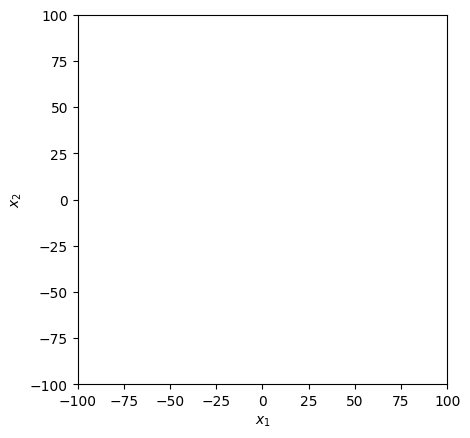

In [ ]:
# plotting the wavefunction
size = 200
xmin = -100
xmax = 100
ymin = -100
ymax = 100
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
mesh = [[psi([i, j], optd[-1]) for i in X] for j in Y]
fig = plt.figure()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
im = plt.imshow(mesh, cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')
plt.show()